<a href="https://colab.research.google.com/github/aryeko/DeepLearning-TAU/blob/main/Ex2/Ex2%20-%20Q1%20-%20CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1
You are required to present two models: 
- (i) using fully connected layers only
- (ii) combining convolution layers and fully connected layers. 

Analyze theperformance of your models.

Notes: 
- (i) For both models you may use Batchnorm and Dropout layers. 
- (ii) The models should be written in PyTorch.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## Load the data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Let us show some of the training images

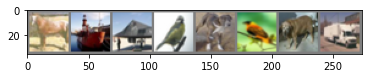

horse  ship plane  bird   dog  bird   dog truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

num_samples = min(batch_size, 8)
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:num_samples]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(num_samples)))

## Use cude GPU if available 

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## Define a fully-connected Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 3 * 32 * 32
        self.fc1 = nn.Linear(self.input_size, self.input_size * 2)
        self.bn1 = nn.BatchNorm1d(self.input_size * 2)
        self.fc2 = nn.Linear(self.input_size * 2, self.input_size * 4)
        self.bn2 = nn.BatchNorm1d(self.input_size * 4)
        self.fc3 = nn.Linear(self.input_size * 4, 4096)
        self.fc4 = nn.Linear(4096, 1024)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 128)
        self.fc7 = nn.Linear(128, 10)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

## Define network test flow

In [6]:
def test_net(net):
  correct = 0
  total = 0
  net.eval()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network 
          outputs = net(inputs)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = (100 * correct / total)
  return accuracy

## Define network training flow

In [7]:
from tqdm import tqdm # progress bar

def train_net(net, optimizer, criterion, epochs=20, print_loss=False):
    net.to(device) # Send the network architecture to the GPU if available
    print_interval = int(batch_size/2)  # 2 prints per batch
    loss_values = []
    acc_values = []
    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # and send to GPU if possible
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % print_interval == print_interval-1: 
                loss_values.append((epoch + 1, i + 1, running_loss / (i+1)))
                if print_loss:
                  print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / (i+1)))
                running_loss = 0.0
        acc = test_net(net)
        acc_values.append(acc)
        if print_loss:
            print(f'epoch [{epoch}] -> Accuracy: {acc}%')
        

    print('Finished Training')
    return loss_values, acc_values

## Define a Loss function, optimizer and train the fully connected net
- Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [8]:
import torch.optim as optim

fc_net = FCNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc_net.parameters(), lr=0.001, momentum=0.9)

fc_loss_vals, fc_accuracy_vals = train_net(fc_net, optimizer, criterion)

100%|██████████| 20/20 [28:56<00:00, 86.82s/it]

Finished Training


## Test the fully connected network

In [9]:
fc_accuracy = test_net(fc_net)
print(f"Fully connected accuracy: {fc_accuracy}%")

Fully connected accuracy: 55.44%


## Define a Convolutional Neural Network

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class ConvFCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3) 
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

## Define a Loss function, optimizer and train the CNN
- Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [11]:
import torch.optim as optim

conv_fc_net = ConvFCNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_fc_net.parameters(), lr=0.001, momentum=0.9)

conv_fc_loss_vals, conv_fc_accuracy_vals = train_net(conv_fc_net, optimizer, criterion)

100%|██████████| 20/20 [06:55<00:00, 20.75s/it]

Finished Training


## Test the CNN

In [12]:
conv_fc_accuracy = test_net(conv_fc_net)
print(f"CNN accuracy: {conv_fc_accuracy}%")

CNN accuracy: 70.94%


## Compare networks

In [13]:
def calc_num_params(net):
  model_parameters = filter(lambda p: p.requires_grad, net.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])

  return params

print(f"FC parameters: {calc_num_params(fc_net)}")
print(f"CNN parameters: {calc_num_params(conv_fc_net)}")


FC parameters: 149549962
CNN parameters: 879498


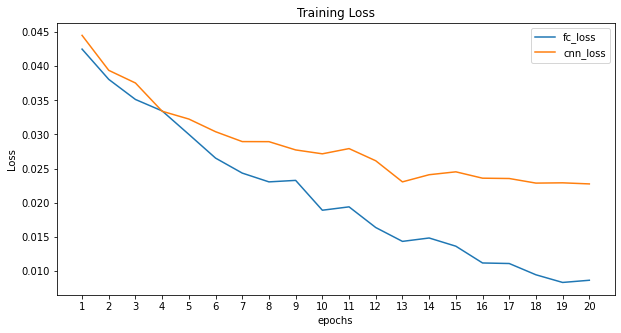

In [22]:
from os import EX_PROTOCOL
num_batches = len(trainloader)
fc_loss = [t[2] for t in fc_loss_vals if t[1] == num_batches]
cnn_loss = [t[2] for t in conv_fc_loss_vals if t[1] == num_batches]
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(fc_loss,label="fc_loss")
plt.plot(cnn_loss,label="cnn_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.xticks(np.arange(0, 20), np.arange(1, 21))
plt.legend()
plt.show()

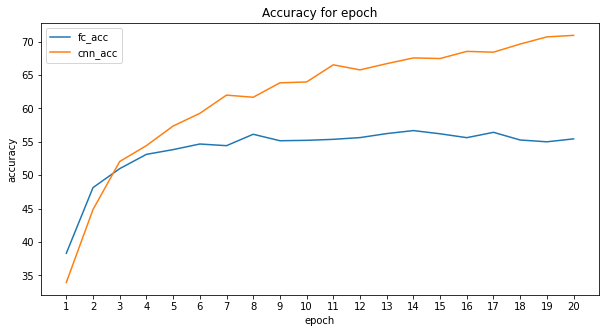

In [23]:
plt.figure(figsize=(10,5))
plt.title("Accuracy for epoch")
plt.plot(fc_accuracy_vals,label="fc_acc")
plt.plot(conv_fc_accuracy_vals,label="cnn_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 20), np.arange(1, 21))
plt.legend()
plt.show()

In [16]:
print(f"Final FC accuracy: {fc_accuracy}%")
print(f"Final CNN accuracy: {conv_fc_accuracy}%")

Final FC accuracy: 55.44%
Final CNN accuracy: 70.94%


## Summary
- The fully connected network has much more parameters since it is not sharing variables
- For the above reason the training time was much longer as well (28 minutes vs 6 for the CNN)!
- Both has same depth
- We tried to use the same number of neurons but the FC network was to big (again, not sharing gparameters)
- Both networks used batch normalization for the first layers which increasing the number of neurons and dropout (40%) for the last layes that decrease the number of neurons
- Without the batch normalization we experirnced very small optimization steps (probably due to vanishing gradinent) 
- Without the droupout layers we had lower accuracy due to overfit
- The training loss of the fully connected layer gets smaller as it has more parameters but the test accuraccy is better with the CNN thanks for its natural feature extraction process using lernable filters